In [34]:
import os

# os.environ["MODIN_ENGINE"] = "ray"
from datetime import datetime, timedelta, timezone
from itertools import cycle, islice

# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from sqlalchemy.orm import Session
from sqlalchemy import select

from utils.db_utils import DB_ENGINE, Category, Restaurant, Item

In [35]:
with Session(DB_ENGINE) as session:
    query = select(Category)
    category_df = pd.read_sql_query(query, session.bind)
    query = select(Restaurant)
    restaurant_df = pd.read_sql_query(query, session.bind)
    query = select(Item)
    # session.query(Item).delete()
    item_df = pd.read_sql_query(query, session.bind)
    # cur = db_con.execute("SELECT * FROM items")
    # results = cur.fetchall()
    # UTC is 8 hours ahead of PT
    # pt_now = datetime.now(timezone.utc) - timedelta(hours=8)
    # db_df.to_csv(f"items_{pt_now.isoformat()}.csv")


In [36]:
category_df

,id,name,rel_url
0,1,24 Hours Food,/category/oakland-ca/24-hours
1,2,Acai food,/category/oakland-ca/acai
2,3,Afghan Food,/category/oakland-ca/afghan
3,4,African Food,/category/oakland-ca/african
4,5,Alcohol,/category/oakland-ca/alcohol
...,...,...,...
972,973,Wine,/category/albany-ca/wine
973,974,Wings,/category/albany-ca/wings
974,975,Wraps,/category/albany-ca/wrap
975,976,Japanese BBQ,/category/albany-ca/yakiniku


In [37]:
category_df['name'].nunique()

196

In [38]:
restaurant_df

,id,name,rating,rel_url,category_id
0,1,Shooting Star Cafe,4.8,/store/shooting-star-cafe/aP9BykDwRviPk6yt0efsYQ,1
1,2,Jack in the Box (2424 International Blvd),4.5,/store/jack-in-the-box-2424-international-blvd...,1
2,3,Walgreens (2300 Otis Dr),4.3,/store/walgreens-2300-otis-dr/alw-PDZzSg2p5nTD...,1
3,4,Taco Bell (2255 Telegraph Avenue),4.6,/store/taco-bell-2255-telegraph-avenue/6jtOSFs...,1
4,5,CVS (1451 Shattuck Avenue),0.0,/store/cvs-1451-shattuck-avenue/LxecUmLMU_mbCF...,1
...,...,...,...,...,...
426,427,Joyride Pizza at Gilman Brewing,0.0,/store/joyride-pizza-at-gilman-brewing/6l6HbQE...,283
427,428,Poggio,0.0,/store/poggio/ywVscC7AU8m6QTAtQ1otiQ,283
428,429,Casa Barotti,4.7,/store/casa-barotti/qnFlB6OEUp6lI_F5ur4zqQ,283
429,430,Belotti Bottega,4.5,/store/belotti-bottega/AlO9B4EFU8WJnSZIrBgfHA,283


In [39]:

item_df

,id,name,description,rel_url,restaurant_id
0,1,Hawaiian Empanada,"cheese, ham and pineapple",Hawaiian Empanada+230,230
1,2,Empanada Beef,Beef and potatoes.,Empanada Beef+230,230
2,3,Empanada Chicken,Chicken and potatoes.,Empanada Chicken+230,230
3,4,Empanada Veggie,"Potatoes, peas, and carrots.",Empanada Veggie+230,230
4,5,Arepa Chicken,"Cheese, chicken, and avocado.",Arepa Chicken+230,230
...,...,...,...,...,...
2215,2216,Fusion Ham,"Ham, turkey, tomatoes, onions, lettuce, cheese...",Fusion Ham+229,229
2216,2217,BLT,"Bread, bacon, lettuce and tomatoes.",BLT+229,229
2217,2218,Vegan K.I,"Bread, lettuce, spinach, tomatoes, onions, avo...",Vegan K.I+229,229
2218,2219,Tuna J.J,"Bread, tomatoes, onions, Tuna Salad.",Tuna J.J+229,229


In [40]:
def extract_city_from_category_url(row):
    # ex category_rel_url: /category/emeryville-ca/african
    return row["rel_url"].split("/", 3)[2].rsplit("-", 1)[0].title()


category_df["city"] = category_df.apply(lambda row: extract_city_from_category_url(row), axis=1)
category_df.head()

,id,name,rel_url,city
0,1,24 Hours Food,/category/oakland-ca/24-hours,Oakland
1,2,Acai food,/category/oakland-ca/acai,Oakland
2,3,Afghan Food,/category/oakland-ca/afghan,Oakland
3,4,African Food,/category/oakland-ca/african,Oakland
4,5,Alcohol,/category/oakland-ca/alcohol,Oakland


In [41]:
category_df.groupby(["city"]).size()

city
Alameda       196
Albany        195
Berkeley      195
Emeryville    196
Oakland       195
dtype: int64

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


/home/dhanush/.pyenv/versions/3.10.0/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


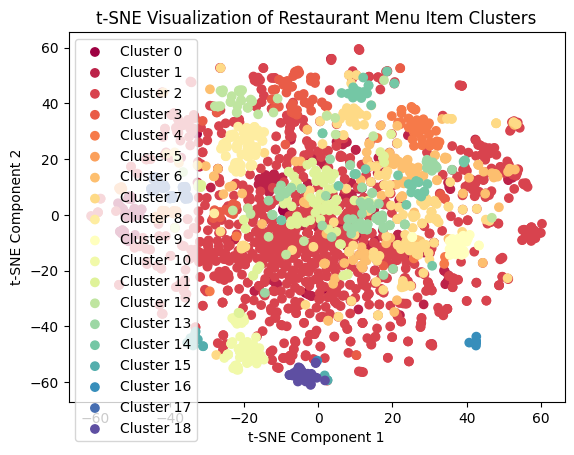

In [42]:
%time

# Assuming your DataFrame is called item_df
# Combining name and description columns
item_df['combined_text'] = item_df['name'] + ' ' + item_df['description']

# Vectorizing the text
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(item_df['combined_text'])

# Clustering with k-means
n_clusters = 19
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
item_df['centroid_id'] = kmeans.fit_predict(X)

# Applying t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Visualizing the results with matplotlib
unique_labels = np.unique(item_df['centroid_id'])
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for centroid_id, color in zip(unique_labels, colors):
    cluster_indices = item_df[item_df['centroid_id'] == centroid_id].index
    plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices, 1], c=[color]*len(cluster_indices), label=f"Cluster {centroid_id}")

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.title('t-SNE Visualization of Restaurant Menu Item Clusters')
plt.show()

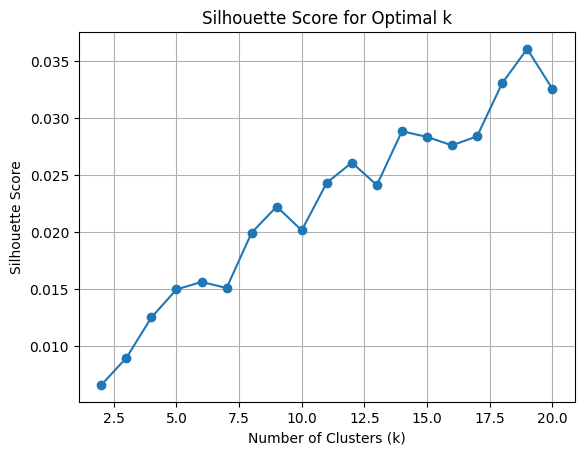

In [43]:
silhouette_scores = []

# Trying different values of k (number of clusters)
k_values = range(2, 21)  # Silhouette score is not defined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # Add the n_init and random_state parameters explicitly
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()

In [45]:
for cluster_id in range(n_clusters):
    cluster_items = item_df[item_df['centroid_id'] == cluster_id][['name', 'description']]
    print(f"Cluster {cluster_id}: # of items = {len(cluster_items)}")
    for _, row in cluster_items.head(5).iterrows():
        print(f"{row['name']}: {row['description']}\n")

Cluster 0: # of items = 58
Hawaiian Empanada: cheese, ham and pineapple 

Arepa Cheese: Cheese and butter.

5-Meat Pizza Slice: 

Large 5-Meat Pizza Whole Pie: 

Ham and Cheese 4": Ham, cheese and a handmade dough.

Cluster 1: # of items = 152
Empanada Chicken: Chicken and potatoes.

Arepa Chicken: Cheese, chicken, and avocado.

Patacon Chicken: Chicken, sweet corn, cheese, and avocado.

Chicken Fries: Chicken, cheese, avocado, and pink homemade sauce.

Side Fries : French fries.

Cluster 2: # of items = 987
Empanada Veggie: Potatoes, peas, and carrots.

Arepa Lechoncita: Colombian bacon, sweet corns, sweet plantains, cheese, and avocado.

Arepa Llanerita: Beef, avocado, cheese, and jalapeno.

Salchipapas: Sausage, cheese, quail eggs, and pink homemade sauce.

Passion Fruit Juice (Juice Maracuya): 

Cluster 3: # of items = 75
MoCa Bonbon Chocolate Topping (10 units): 

Hot Bomb: Noble milk chocolate capsule filled whit creamy coffee and dark chocolate ganache.

Muscle Milk Chocolate 14